In [1]:
# Import PyTorch
import torch
from torch import nn
import torch.optim as optim

# Import torchvision 
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchsummary import summary

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1
torchvision version: 0.20.1


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
NUM_WORKERS = os.cpu_count()
print(NUM_WORKERS)

4


In [4]:
import os
def scan_directory(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
image_path = "C:/Users/Majid/data/Cats_and_Dogs"
scan_directory(image_path)

There are 3 directories and 0 images in 'C:/Users/Majid/data/Cats_and_Dogs'.
There are 0 directories and 6 images in 'C:/Users/Majid/data/Cats_and_Dogs\predict'.
There are 2 directories and 0 images in 'C:/Users/Majid/data/Cats_and_Dogs\test'.
There are 0 directories and 69 images in 'C:/Users/Majid/data/Cats_and_Dogs\test\cats'.
There are 0 directories and 69 images in 'C:/Users/Majid/data/Cats_and_Dogs\test\dogs'.
There are 2 directories and 0 images in 'C:/Users/Majid/data/Cats_and_Dogs\train'.
There are 0 directories and 278 images in 'C:/Users/Majid/data/Cats_and_Dogs\train\cats'.
There are 0 directories and 277 images in 'C:/Users/Majid/data/Cats_and_Dogs\train\dogs'.


In [6]:
# Setup train and testing paths
train_dir = "C:/Users/Majid/data/Cats_and_Dogs/train"
test_dir = "C:/Users/Majid/data/Cats_and_Dogs/test"

In [7]:
# A function to select a random image from a directory
def random_image_path(directory):
    image_files = [f for f in os.listdir(directory)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    if not image_files:
        raise ValueError(f"No image files found in: {directory}")
    img_name = random.choice(image_files)
    return os.path.join(directory, img_name), img_name

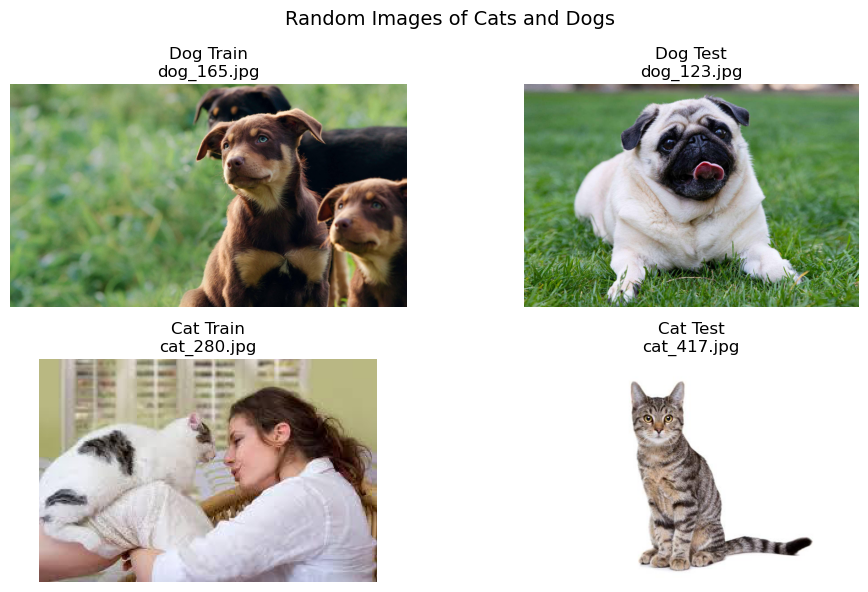

In [8]:

def plot_random_image_from_dir(dir_dog_train, dir_dog_test, dir_cat_train, dir_cat_test):
    
    # Get random images
    image_path_dog_train, random_image_dog_train = random_image_path(dir_dog_train)
    image_path_dog_test,  random_image_dog_test  = random_image_path(dir_dog_test)
    image_path_cat_train, random_image_cat_train = random_image_path(dir_cat_train)
    image_path_cat_test,  random_image_cat_test  = random_image_path(dir_cat_test)

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle('Random Images of Cats and Dogs', fontsize=14)

    # Plot Dog Train
    image = Image.open(image_path_dog_train)
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f"Dog Train\n{random_image_dog_train}")
    axes[0, 0].axis('off')

    # Plot Dog Test
    image = Image.open(image_path_dog_test)
    axes[0, 1].imshow(image)
    axes[0, 1].set_title(f"Dog Test\n{random_image_dog_test}")
    axes[0, 1].axis('off')

    # Plot Cat Train
    image = Image.open(image_path_cat_train)
    axes[1, 0].imshow(image)
    axes[1, 0].set_title(f"Cat Train\n{random_image_cat_train}")
    axes[1, 0].axis('off')

    # Plot Cat Test
    image = Image.open(image_path_cat_test)
    axes[1, 1].imshow(image)
    axes[1, 1].set_title(f"Cat Test\n{random_image_cat_test}")
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
dir_dog_test = test_dir+"/dogs"
dir_dog_train = train_dir+"/dogs"
dir_cat_test = test_dir+"/cats"
dir_cat_train = train_dir+"/cats"

plot_random_image_from_dir(dir_dog_train, dir_dog_test, dir_cat_train, dir_cat_test)

In [9]:
"""
    Transforming data with torchvision.transforms
    torchvision.transforms contains many pre-built methods for 
        formatting images,
        turning them into tensors
        manipulating them for data augmentation

    Data augmentation is the process of altering your data in such a way that artificially increase the diversity of training set.
    Usually don't perform data augmentation on the test set.
    The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.
"""

# A function to transform train and test data and augment train data
def transform_data_fn(image_size=128):
    # Augment data
    train_data_transform = transforms.Compose([
        # Resize the images to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # (Augmenting data) - Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
        # how intense
        transforms.TrivialAugmentWide(num_magnitude_bins=40), 
        # Turn the image into a torch.Tensor
        transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Don't augment test data
    test_data_transform = transforms.Compose([
        # Resize the image to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    return train_data_transform, test_data_transform

In [10]:
train_data_transform, test_data_transform = transform_data_fn(image_size=128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].


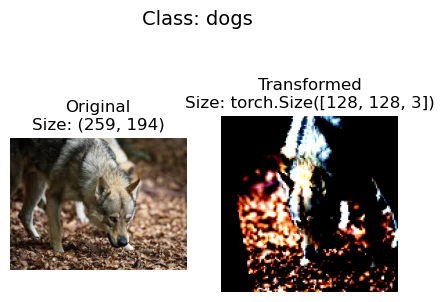

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


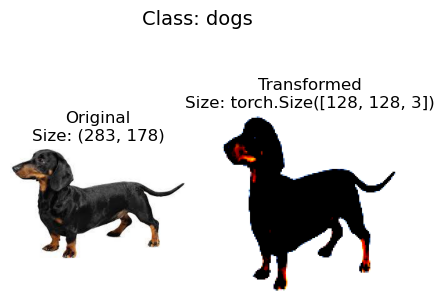

In [11]:
# Function to plot original and transformed images
def plot_transformed_image(image_path, transform):
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2, figsize=(5, 4))
        
        ax[0].imshow(f)
        ax[0].set_title(f"Original\nSize: {f.size}")
        ax[0].axis("off")
        
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
        ax[1].axis("off")
        
        fig.suptitle(f"Class: {os.path.basename(os.path.dirname(image_path))}", fontsize=14)
        plt.show()

# Train data can be ugmented.
dir_dog_train = train_dir+"/dogs"
image_path_dog_train, random_image_dog_train = random_image_path(dir_dog_train)
plot_transformed_image(image_path_dog_train, train_data_transform)

# test data can't be ugmented.
dir_dog_test = test_dir+"/dogs"
image_path_dog_test, random_image_dog_test = random_image_path(dir_dog_test)
plot_transformed_image(image_path_dog_test, test_data_transform)


In [12]:
"""
    Loading Image Data Using ImageFolder
    Let's test it out on our data folders train_dir and test_dir 
    Passing in transform=data_transform to turn our images into tensors.
"""
# A function to load data from directoris.

def load_train_test_data_fn(train_dir, test_dir, train_data_transform, test_data_transform):
    
    train_data = datasets.ImageFolder(root = train_dir,                   # target folder of images
                                     transform = train_data_transform,    # transforms to perform on data (images)
                                     target_transform = None)             # transforms to perform on labels (if necessary)

    test_data = datasets.ImageFolder(root = test_dir,
                                    transform = test_data_transform)
    
    return train_data, test_data

In [13]:
train_data, test_data = load_train_test_data_fn(
    train_dir = train_dir,
    test_dir = test_dir,
    train_data_transform = train_data_transform,
    test_data_transform = test_data_transform
)

print(train_data, "\n--------------------------------------------------\n")
print(test_data)

Dataset ImageFolder
    Number of datapoints: 555
    Root location: C:/Users/Majid/data/Cats_and_Dogs/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=40, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 
--------------------------------------------------

Dataset ImageFolder
    Number of datapoints: 138
    Root location: C:/Users/Majid/data/Cats_and_Dogs/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [14]:
# Get class names as a list from train data
class_names = train_data.classes
print(class_names)

['cats', 'dogs']


In [15]:
# Can also get class names as a dict from train data
class_dict = train_data.class_to_idx
class_dict

{'cats': 0, 'dogs': 1}

In [16]:
# Check the lengths
len(train_data), len(test_data)

(555, 138)

In [17]:
"""
    Define a function to get the class names from a target directory
"""

def class_names(directory):

    # 1. Scanning the target directory to get the class names.
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. If class names not found, then Raise an error. 
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels
    class_index = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_index

In [18]:
classes, classes_index = class_names(test_dir)
print(classes)
print(classes_index)

['cats', 'dogs']
{'cats': 0, 'dogs': 1}


In [19]:
"""
    Get the information of train data 0 and it's label.
"""
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[ 0.6906,  0.6392,  0.6563,  ...,  0.9303,  1.0159,  1.0159],
         [ 0.7077,  0.6734,  0.6734,  ...,  0.9474,  1.0159,  1.0331],
         [ 0.7248,  0.6906,  0.6906,  ...,  0.9988,  1.0673,  1.0673],
         ...,
         [ 1.3584,  1.3070,  1.3413,  ...,  1.2557,  1.2385,  1.2214],
         [ 1.2728,  1.2557,  1.2557,  ...,  1.2214,  1.2557,  1.2214],
         [ 1.1700,  1.2214,  1.1700,  ...,  1.2385,  1.2557,  1.2385]],

        [[ 1.1155,  1.0630,  1.0805,  ...,  0.5728,  0.0301,  0.0651],
         [ 1.1331,  1.0980,  1.0980,  ...,  0.5903,  0.0301,  0.0826],
         [ 1.1506,  1.1155,  1.1155,  ...,  0.6429,  0.1176,  0.0826],
         ...,
         [ 1.2031,  1.1856,  1.2206,  ...,  1.5357,  1.5182,  1.5007],
         [ 1.2206,  1.2031,  1.2381,  ...,  1.5007,  1.5357,  1.5007],
         [ 1.2731,  1.2556,  1.2731,  ...,  1.5182,  1.5357,  1.5182]],

        [[ 1.2457,  1.1934,  1.2108,  ...,  0.3568, -0.3753, -0.3055],
         [ 1.2631,  1.2282,  1.

In [20]:
"""
    Rearrange the order of dimensions
    Change from: [color_channels, height, width] --->>> to [height, width, color_channels]
"""

img_permute = img.permute(1, 2, 0)
# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].


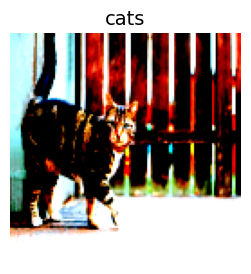

In [21]:
# Plot the image of a train train_data
# Image has less quality because image resized from 512x512 to 64x64 pixels.
plt.figure(figsize=(4, 3))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(classes[label], fontsize=14);

In [22]:
"""
    Turn loaded images into DataLoader's
    Turn dataset into dataloader by using using torch.utils.data.DataLoader.
"""

# A function to create train and test data loader

def train_test_dataloader_fn(train_data, test_data, batch_size=32, num_workers=1, shuffle=True):
    train_dataloader = DataLoader(dataset = train_data,
                                 batch_size = batch_size,          # how many samples per batch?
                                 num_workers = num_workers,         # how many subprocesses to use for data loading? (higher = more)
                                 shuffle = True)          # shuffle the data?
    
    test_dataloader = DataLoader(dataset = test_data,
                                batch_size = batch_size,
                                num_workers = num_workers,
                                shuffle = False)

    return train_dataloader, test_dataloader

In [23]:
batch_size = 1
num_workers = os.cpu_count()

train_dataloader, test_dataloader = train_test_dataloader_fn(
    train_data = train_data,
    test_data = test_data,
    batch_size = batch_size,
    num_workers = num_workers,
    shuffle = True
)

print(train_dataloader,"\n", test_dataloader)

In [24]:
"""
  Batch size will now be 1
  try changing the batch_size parameter above and see what happens
"""
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [25]:
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[[-1.8097, -1.7412, -1.7069,  ..., -1.6727, -1.6555, -1.6384],
          [-1.7412, -1.6727, -1.6384,  ..., -1.6384, -1.6384, -1.6213],
          [-1.6555, -1.5870, -1.5870,  ..., -1.6213, -1.6042, -1.5870],
          ...,
          [-1.7925, -1.7925, -1.7754,  ..., -1.1760, -1.2103, -1.2445],
          [-1.7754, -1.7754, -1.7754,  ..., -1.1760, -1.2274, -1.2617],
          [-1.7925, -1.7754, -1.7754,  ..., -1.1760, -1.2445, -1.2959]],

         [[-1.7031, -1.6155, -1.5630,  ..., -1.3704, -1.3529, -1.3354],
          [-1.6331, -1.5455, -1.4930,  ..., -1.3354, -1.3354, -1.3179],
          [-1.5455, -1.4580, -1.4405,  ..., -1.3179, -1.3004, -1.2829],
          ...,
          [-1.3704, -1.3704, -1.3704,  ..., -0.8627, -0.9153, -0.9503],
          [-1.3529, -1.3529, -1.3704,  ..., -0.8978, -0.9328, -0.9678],
          [-1.3704, -1.3529, -1.3529,  ..., -0.9153, -0.9678, -1.0028]],

         [[-1.5779, -1.4907, -1.4559,  ..., -1.2119, -1.1944, -1.1770],
          [-1.50

In [26]:
img_permute = img.permute(0, 2, 3, 1)
# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [batchs, color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [batchs, height, width, color_channels]")

Original shape: torch.Size([1, 3, 128, 128]) -> [batchs, color_channels, height, width]
Image permute shape: torch.Size([1, 128, 128, 3]) -> [batchs, height, width, color_channels]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.343704].


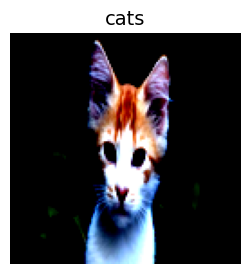

In [27]:
# Plot the image of a train train_data
# Image has less quality because image resized from 512x512 to 64x64 pixels.
plt.figure(figsize=(4, 3))
# Plot the first image of the batch
plt.imshow(img_permute[0])
plt.axis("off")
plt.title(classes[label], fontsize=14);

In [28]:
# Creating transforms and loading data for Model 0

# Setup train and testing paths
train_dir = "C:/Users/Majid/data/Cats_and_Dogs/train"
test_dir = "C:/Users/Majid/data/Cats_and_Dogs/test"

# Setup batch size and number of workers 
batch_size = 8
num_workers = os.cpu_count()
image_size = 128

# 1. Create a transfomres for train data (with augmentation), and test data (without augmentation)
train_data_transform, test_data_transform = transform_data_fn(image_size=image_size)

# 2. Load train and test data from the directories
train_data, test_data = load_train_test_data_fn(
    train_dir=train_dir,
    test_dir = test_dir,
    train_data_transform = train_data_transform,
    test_data_transform = test_data_transform
)

# 3. Create data loader for train and test data
train_dataloader, test_dataloader = train_test_dataloader_fn(
    train_data = train_data,
    test_data = test_data,
    batch_size = batch_size,
    num_workers = num_workers,
    shuffle = True
)

In [29]:
"""
    Create a baseline model: Model 0
    Is the Simplest model and is the subclass of nn.Module.
    Our baseline model consists of two nn.Linear()
    We use a nn.Flatten() layer that compresses the dimensions of a tensor into a single vector.
"""
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)


# Get a single sample
batch_image, label_batch = next(iter(train_dataloader))
x = batch_image[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 16384]) -> [color_channels, height*width]


In [30]:
class baseModelCatDog(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, image_size=128):
        super().__init__()
        self.ConvBlock1 = nn.Sequential(
            nn.Conv2d(input_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        size_flatten = int(hidden_size*(image_size/4)*(image_size/4))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=size_flatten, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_size),
        )

    def forward(self, x: torch.Tensor):
        x = self.ConvBlock1(x)   # print(x.shape)
        x = self.ConvBlock2(x)   # print(x.shape)
        x = self.classifier(x)     # print(x.shape)
        return x

In [31]:
torch.manual_seed(42)
# Pictures shape 3*128*128=49152
# Binary classification, output shape is 2
model_0 = baseModelCatDog(
    input_size=3,    # Number of colors
    hidden_size=32,
    output_size=1,
    image_size=image_size
)
model_0.to(device)

baseModelCatDog(
  (ConvBlock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvBlock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [32]:
summary(model_0, input_size=torch.Size([3,128,128]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
              ReLU-4         [-1, 32, 128, 128]               0
         MaxPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           9,248
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
        MaxPool2d-10           [-1, 32, 32, 32]               0
          Flatten-11                [-1, 32768]               0
           Linear-12                   [-1, 32]       1,048,608
             ReLU-13                   [-1, 32]               0
           Linear-14                   

In [33]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))
print(label_batch.shape, label_batch.unique())
# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

torch.Size([8]) tensor([0, 1])
Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[-0.0846]])

Output prediction probabilities:
tensor([[1.]])

Output prediction label:
tensor([0])

Actual label:
1


In [34]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    preds = (torch.sigmoid(y_pred) > 0.5).float()
    correct = (preds == y_true).float().sum()
    acc = correct / len(y_true)
    return acc * 100

In [35]:
def train_model_with_dataloaders(model, train_loader, test_loader, epochs=10, learning_rate = 0.003):

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # Setup loss functions and optimimizer
    criterion = nn.BCEWithLogitsLoss() # For Binary classification and when not using sigmoid at the last layer of model.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, epoch_train_acc = 0., 0.

        # ---- TRAINING LOOP ----
        for batch_features, batch_targets in train_loader:
            # shape: [batch_size, 1]
            batch_features, batch_targets = batch_features.to(device), batch_targets.unsqueeze(1).float().to(device)

            # 1.
            optimizer.zero_grad()

            # 2. Prediction (Forward pass)
            batch_predictions = model(batch_features)

            # 3. Compute loss and accuracy
            batch_loss = criterion(batch_predictions, batch_targets)
            batch_acc = accuracy_fn(batch_targets, batch_predictions)

            batch_loss.backward()
            optimizer.step()

            epoch_train_loss += batch_loss.item()
            epoch_train_acc += batch_acc

        # Average over all batches
        epoch_train_loss /= len(train_loader)
        epoch_train_acc /= len(train_loader)

        # ---- EVALUATION LOOP ----
        model.eval()
        epoch_test_loss, epoch_test_acc = 0., 0.
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                # shape: [batch_size, 1]
                batch_features, batch_targets = batch_features.to(device), batch_targets.unsqueeze(1).float().to(device)
                
                batch_predictions = model(batch_features)
                batch_loss = criterion(batch_predictions, batch_targets)
                batch_acc = accuracy_fn(batch_targets, batch_predictions)

                epoch_test_loss += batch_loss.item()
                epoch_test_acc += batch_acc

        epoch_test_loss /= len(test_loader)
        epoch_test_acc /= len(test_loader)

        # Store results
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)

        # Print all epochs
        if epoch % 1 == 0:
            print(f"Epoch [{epoch}/{epochs}] | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [36]:
train_losses_0, test_losses_0, train_accuracies_0, test_accuracies_0 = train_model_with_dataloaders(
    model_0, 
    train_dataloader, 
    test_dataloader,
    epochs=10,
    learning_rate = 0.0001
)

Epoch [0/10] | Train Loss: 0.6955 | Train Acc: 49.76% | Test Loss: 0.6943 | Test Acc: 47.92%
Epoch [1/10] | Train Loss: 0.6934 | Train Acc: 50.60% | Test Loss: 0.6931 | Test Acc: 47.22%
Epoch [2/10] | Train Loss: 0.6917 | Train Acc: 52.44% | Test Loss: 0.6912 | Test Acc: 57.64%
Epoch [3/10] | Train Loss: 0.6859 | Train Acc: 57.56% | Test Loss: 0.6889 | Test Acc: 54.17%
Epoch [4/10] | Train Loss: 0.6824 | Train Acc: 56.37% | Test Loss: 0.6888 | Test Acc: 59.72%
Epoch [5/10] | Train Loss: 0.6636 | Train Acc: 61.25% | Test Loss: 0.7092 | Test Acc: 60.42%
Epoch [6/10] | Train Loss: 0.6819 | Train Acc: 61.01% | Test Loss: 0.6897 | Test Acc: 59.03%
Epoch [7/10] | Train Loss: 0.6763 | Train Acc: 63.39% | Test Loss: 0.6927 | Test Acc: 61.11%
Epoch [8/10] | Train Loss: 0.6752 | Train Acc: 59.05% | Test Loss: 0.6881 | Test Acc: 54.17%
Epoch [9/10] | Train Loss: 0.6635 | Train Acc: 62.20% | Test Loss: 0.6899 | Test Acc: 56.25%


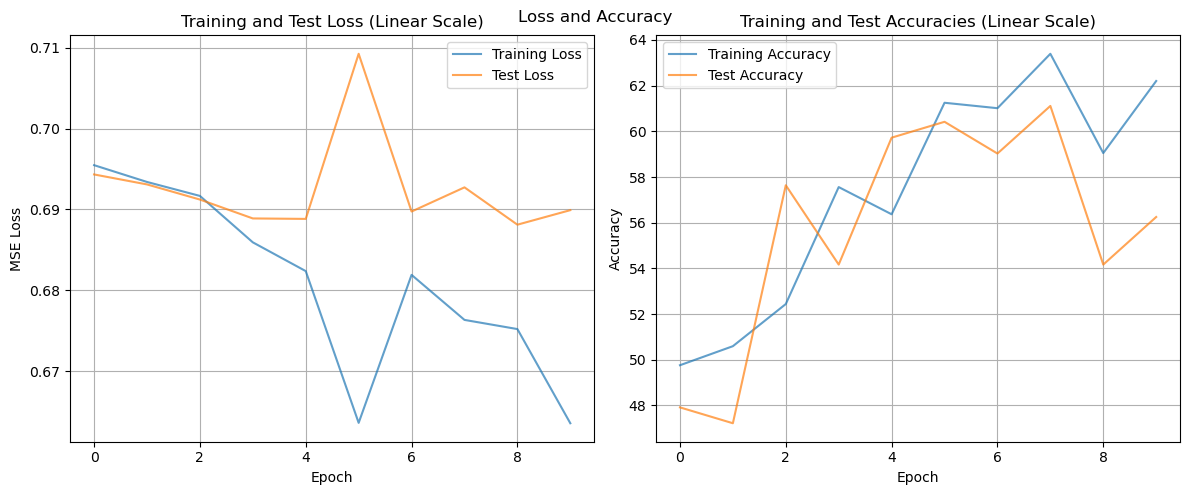

In [37]:
# Plot training and test losses

def plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, alpha=0.7):

    fig, axes = plt.subplots(1,2,figsize=(12, 5)) 

    axes[0].plot(train_losses, label='Training Loss', alpha=0.7)
    axes[0].plot(test_losses, label='Test Loss', alpha=0.7)
    axes[0].set_title("Training and Test Loss (Linear Scale)")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("MSE Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(train_accuracies, label='Training Accuracy', alpha=0.7)
    axes[1].plot(test_accuracies, label='Test Accuracy', alpha=0.7)
    axes[1].set_title("Training and Test Accuracies (Linear Scale)")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()
    
    fig.suptitle('Loss and Accuracy')

    plt.show()

plot_loss_accuracy(train_losses_0, test_losses_0, train_accuracies_0, test_accuracies_0)


In [38]:
import torch
from torch import nn

class ImprovedCatDogModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, output_size=1, image_size=128):
        super().__init__()

        self.features = nn.Sequential(
            # --- Block 1 ---
            nn.Conv2d(input_size, hidden_size, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            # --- Block 2 ---
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(hidden_size * 2, hidden_size * 2, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
        )

        flatten_size = int(hidden_size*2*(image_size/4)*(image_size/4))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 128),  # assuming input 128x128
            nn.ReLU(),
            nn.Linear(128, 32),  # assuming input 128x128
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [39]:
model_1 = ImprovedCatDogModel(input_size=3, hidden_size=32, output_size=1, image_size=image_size).to(device)

In [40]:
summary(model_1, input_size=torch.Size([3,128,128]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
              ReLU-4         [-1, 32, 128, 128]               0
         MaxPool2d-5           [-1, 32, 64, 64]               0
           Dropout-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
             ReLU-10           [-1, 64, 64, 64]               0
        MaxPool2d-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
          Flatten-13                [-1, 65536]               0
           Linear-14                  [

In [41]:
train_losses_1, test_losses_1, train_accuracies_1, test_accuracies_1 = train_model_with_dataloaders(
    model_1,
    train_dataloader,
    test_dataloader,
    epochs=10,
    learning_rate = 0.0001
)

Epoch [0/10] | Train Loss: 0.6921 | Train Acc: 52.14% | Test Loss: 0.6901 | Test Acc: 52.08%
Epoch [1/10] | Train Loss: 0.6879 | Train Acc: 56.49% | Test Loss: 0.6846 | Test Acc: 54.17%
Epoch [2/10] | Train Loss: 0.6801 | Train Acc: 54.40% | Test Loss: 0.6900 | Test Acc: 53.47%
Epoch [3/10] | Train Loss: 0.6699 | Train Acc: 61.01% | Test Loss: 0.6788 | Test Acc: 55.56%
Epoch [4/10] | Train Loss: 0.6708 | Train Acc: 59.23% | Test Loss: 0.6804 | Test Acc: 56.25%
Epoch [5/10] | Train Loss: 0.6323 | Train Acc: 66.43% | Test Loss: 0.6995 | Test Acc: 56.94%
Epoch [6/10] | Train Loss: 0.6427 | Train Acc: 64.05% | Test Loss: 0.6646 | Test Acc: 61.11%
Epoch [7/10] | Train Loss: 0.6437 | Train Acc: 63.27% | Test Loss: 0.6870 | Test Acc: 52.78%
Epoch [8/10] | Train Loss: 0.6299 | Train Acc: 64.23% | Test Loss: 0.6698 | Test Acc: 63.19%
Epoch [9/10] | Train Loss: 0.6270 | Train Acc: 64.52% | Test Loss: 0.6939 | Test Acc: 56.94%


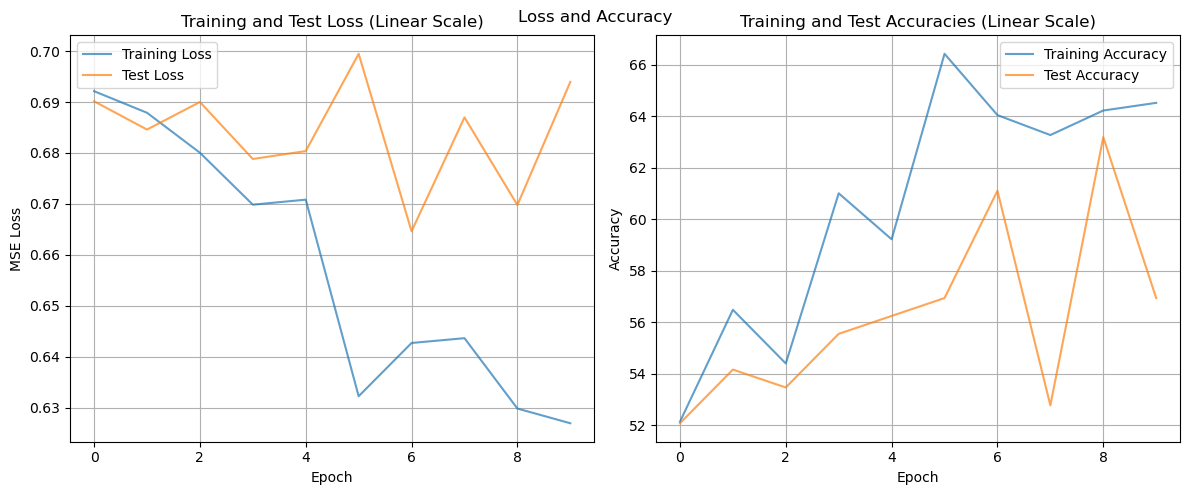

In [42]:
plot_loss_accuracy(train_losses_1, test_losses_1, train_accuracies_1, test_accuracies_1)

In [43]:
"""
    Predict the label of an aribitrary image.
"""

def predict_image(model, image_path, device, image_size):
    # Step 1: Define transforms (must match training)
    transform = transforms.Compose([
       # Resize the images to 128*128: our default size
        transforms.Resize(size=(image_size, image_size)),
        # Turn the image into a torch.Tensor
        transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Step 2: Open image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension

    # Step 3: Model in eval mode
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.sigmoid(output).item()  # convert logits to probability

    # Step 4: Interpret result
    label = "Dog 🐶" if prediction > 0.5 else "Cat 🐱"

    return label, prediction

image_path = "C:/Users/Majid/data/Cats_and_Dogs/predict/cat-3.jfif"
image_size = 128  # Same size
device = "cuda" if torch.cuda.is_available() else "cpu"

label, prediction = predict_image(model_0, image_path, device, image_size)
print(f"Prediction: {label} (score={prediction:.4f})")

Prediction: Cat 🐱 (score=0.4762)
